# Import

In [172]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Dataset

In [148]:
insurance = pd.read_csv('../Dataset/data/insurance.csv')
insurance.info()
insurance.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1272 non-null   float64
 1   sex       1272 non-null   object 
 2   bmi       1272 non-null   float64
 3   children  1272 non-null   float64
 4   smoker    1272 non-null   object 
 5   region    1272 non-null   object 
 6   charges   1284 non-null   object 
dtypes: float64(3), object(4)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
1211,39.0,man,34.100,2.0,no,southeast,23563.01618
1208,37.0,female,25.555,1.0,yes,Northeast,20296.86345
731,53.0,male,21.400,1.0,no,southwest,$10065.413
677,60.0,male,31.350,3.0,yes,Northwest,46130.5265
183,44.0,female,26.410,0.0,no,Northwest,$7419.4779
119,37.0,female,23.370,2.0,no,northwest,6686.4313
755,NaN,male,NaN,2.0,no,NaN,5031.26955
691,-47.0,male,36.200,-1.0,no,southwest,$8068.185
17,-23.0,male,23.845,0.0,no,northeast,$2395.17155
445,-45.0,female,33.100,0.0,no,Southwest,7345.084


# Step-1 : Data Cleaning

In [ ]:
insurance_filled = insurance.dropna().copy()
insurance_filled['region'] = insurance_filled['region'].str.lower()


FEMALE = 'female'
MALE = 'male'

sex_map = {
    'F' : FEMALE,  
    'woman' : FEMALE,
    'man' : MALE,
    'M' : MALE
}
insurance_filled['sex'] = insurance_filled['sex'].replace(sex_map)

insurance_filled['smoker'] = (insurance_filled['smoker'] == 'yes')

insurance_filled['charges'] = insurance_filled['charges'].str.strip('$').astype('float64')

insurance_filled['age'] = abs(insurance_filled['age']).astype('int64')

insurance_filled.to_csv('../Dataset/data/insurance_cleaned.csv', index=False)

# Step-2: Scatterplots to view the relationship between

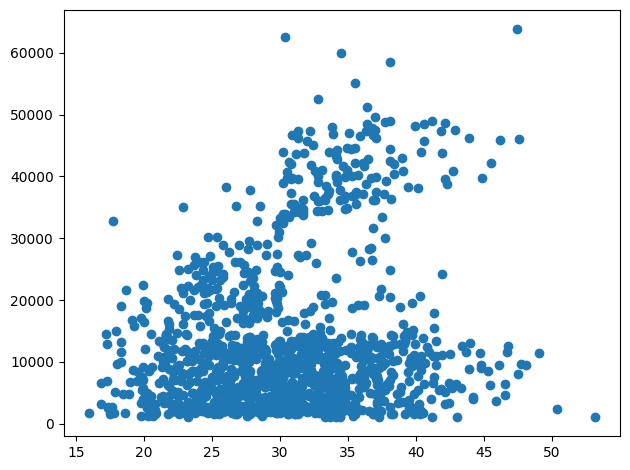

In [146]:
plt.scatter(insurance_filled['bmi'], insurance_filled['charges'])

plt.tight_layout()
plt.show()

# Step-3: Prepare Data for Model Training

In [188]:
df = pd.get_dummies(insurance_filled, prefix=['region'], columns=['region'], dtype='int64')
df.drop(columns=['region_southeast'])

df['smoker'] = df['smoker'].astype('int64')
df['is_male'] = (df['sex'] == 'male').astype('int64')
df = df.drop(columns=['sex'])
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1207 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1207 non-null   int64  
 1   bmi               1207 non-null   float64
 2   children          1207 non-null   float64
 3   smoker            1207 non-null   int64  
 4   charges           1207 non-null   float64
 5   region_northeast  1207 non-null   int64  
 6   region_northwest  1207 non-null   int64  
 7   region_southeast  1207 non-null   int64  
 8   region_southwest  1207 non-null   int64  
 9   is_male           1207 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 103.7 KB


# Step-4: Fit a Linear Regression model to our Data

In [194]:
X = df.drop(columns=['charges'])
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse
r2

0.7048413291217552

# Test Data with the validation set

In [208]:
def preprocess_df(input_dataframe, reference_training_columns):
    df_processed = input_dataframe.copy()
    if 'smoker' in df_processed.columns:
        df_processed['smoker'] = (df_processed['smoker'] == 'yes').astype('int64')
    
    if 'sex' in df_processed.columns:
        df_processed['is_male'] = (df_processed['sex'] == 'male').astype('int64')
        df_processed = df_processed.drop(columns=['sex'])

    if 'region' in df_processed.columns:
        df_processed = pd.get_dummies(df_processed, prefix='region', columns=['region'], dtype='int64')

    for col in reference_training_columns:
        if col not in df_processed.columns:
            df_processed[col] = 0

    df_processed = df_processed[reference_training_columns]
    
    return df_processed

In [212]:
val_df = pd.read_csv('../Dataset/data/validation_dataset.csv')
if 'X_train' in locals():
    input_df = preprocess_df(val_df, X_train.columns) 

    predictions = model.predict(input_df)

    validation_data = val_df.copy()
    validation_data['predicted_charges'] = predictions

    validation_data.loc[validation_data['predicted_charges'] < 1000, 'predicted_charges'] = 1000
    print(validation_data.head())


    age     sex        bmi  children smoker     region  predicted_charges
0  18.0  female  24.090000       1.0     no  southeast        1000.000000
1  39.0    male  26.410000       0.0    yes  northeast       31133.450387
2  27.0    male  29.150000       0.0    yes  southeast       27965.611569
3  71.0    male  65.502135      13.0    yes  southeast       55748.823085
4  28.0    male  38.060000       0.0     no  southeast        6867.894254
